In [1]:
import transformers
import torch
import torch.nn as nn
from torch.utils import data
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import ast
import time
from others.config import *

hyperparameters = config['hyperparameters']
gpu = ('cuda:0')

Data Exploration

In [2]:
dataset = pd.read_csv('dataset/Corona_NLP_train.csv')

In [3]:
dataset.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [4]:
dataset['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [5]:
dataset['label'] = dataset['Sentiment'].map({'Extremely Negative':0, 'Negative':1, 'Neutral':2, 'Positive':3, 'Extremely Positive':4})
dataset = dataset.rename(columns = {'OriginalTweet' : 'doc'})

In [6]:
dataset = dataset.iloc[:,4::2]

<AxesSubplot:xlabel='label', ylabel='count'>

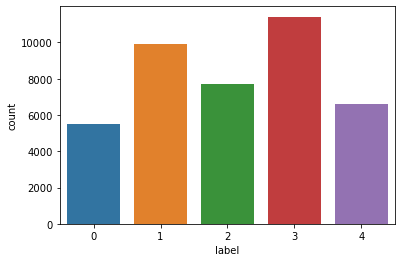

In [7]:
sns.countplot(dataset.label)

In [8]:
len(dataset)

41157

In [9]:
doc_len = [len(dataset.doc[i].split()) for i in range(len(dataset))]
longest_len = max(doc_len)
print('The longest doc in dataset is {} words, {} Sentiment Score, with idx {}'.format(longest_len, int(dataset.label[doc_len.index(longest_len)]), doc_len.index(longest_len)))

The longest doc in dataset is 64 words, 1 Sentiment Score, with idx 11106


<AxesSubplot:ylabel='Density'>

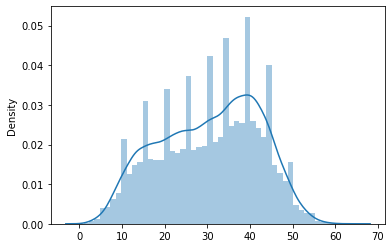

In [10]:
sns.distplot(doc_len)

Data Preprocessing

In [11]:
train, validation = train_test_split(dataset, test_size = 0.3, random_state = int(hyperparameters['RANDOM_STATE']))

In [12]:
len(train), len(validation)

(28809, 12348)

In [13]:
class CustomDataset(data.Dataset):
    def __init__(self, docs, labels, tokenizer, max_len):
        self.docs = docs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.docs)

    def __getitem__(self, item):
        docs = str(self.docs[item])
        labels = int(self.labels[item])
        encoded = tokenizer.encode_plus(
            docs,
            max_length = self.max_len,
            add_special_tokens = True,
            pad_to_max_length = True,
            return_attention_mask = True,
            truncation=True,
            return_tensors = 'pt'
        )
        return docs, labels, torch.squeeze(encoded['input_ids'], 0), torch.squeeze(encoded['attention_mask'], 0)

In [14]:
tokenizer = transformers.BertTokenizer.from_pretrained(hyperparameters['MODEL'])

In [15]:
train_encoded = CustomDataset(train.doc.to_numpy(), train.label.to_numpy(), tokenizer, int(hyperparameters['MAX_LEN']))
validation_encoded = CustomDataset(validation.doc.to_numpy(), validation.label.to_numpy(), tokenizer, int(hyperparameters['MAX_LEN']))

In [16]:
train_loader = data.DataLoader(train_encoded, batch_size = ast.literal_eval(hyperparameters['BATCH_SIZES'])[0])
validation_loader = data.DataLoader(validation_encoded, batch_size = ast.literal_eval(hyperparameters['BATCH_SIZES'])[1])

In [17]:
for docs, labels, input_ids, attention_mask in train_loader:
    print('lables: {}, shape: {}'.format(labels, labels.shape))
    print('input_ids: {}, shape: {}'.format(input_ids, input_ids.shape))
    print('attention_mask: {}, shape: {}'.format(attention_mask, attention_mask.shape))
    break

lables: tensor([2, 1, 1, 2, 0, 4, 1, 1, 4, 4, 2, 4, 4, 1, 1, 3, 3, 1, 3, 0, 2, 4, 1, 2,
        1, 0, 3, 4, 1, 1, 2, 0, 2, 1, 1, 1, 3, 4, 3, 3, 4, 2, 2, 1, 4, 1, 4, 2,
        1, 1, 0, 3, 1, 1, 1, 1, 0, 2, 1, 4, 0, 2, 0, 1]), shape: torch.Size([64])
input_ids: tensor([[  101, 14159,  6071,  ...,  1658,   102,     0],
        [  101,  1109,  2670,  ...,     0,     0,     0],
        [  101,   108,  1884,  ...,     0,     0,     0],
        ...,
        [  101,  2431, 21051,  ...,     0,     0,     0],
        [  101,  3446,  1110,  ...,   132, 12634,   102],
        [  101,   108,  2295,  ...,     0,     0,     0]]), shape: torch.Size([64, 64])
attention_mask: tensor([[1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), shape: torch.Size([64, 64])


In [18]:
for docs, labels, input_ids, attention_mask in validation_loader:
    print('lables: {}, shape: {}'.format(labels, labels.shape))
    print('input_ids: {}, shape: {}'.format(input_ids, input_ids.shape))
    print('attention_mask: {}, shape: {}'.format(attention_mask, attention_mask.shape))
    break

lables: tensor([3, 0, 1, 3, 0, 1, 1, 4, 1, 4, 1, 1, 2, 4, 1, 3, 0, 1, 0, 4, 0, 2, 0, 2,
        3, 4, 4, 2, 1, 4, 1, 1, 0, 1, 3, 3, 4, 3, 1, 1, 1, 3, 2, 2, 3, 4, 3, 0,
        3, 2, 3, 2, 4, 1, 0, 2, 1, 2, 1, 0, 3, 1, 0, 4, 1, 0, 1, 0, 4, 4, 4, 1,
        4, 3, 2, 4, 1, 3, 1, 4, 0, 2, 1, 1, 1, 1, 3, 1, 3, 0, 1, 3, 3, 0, 4, 0,
        2, 3, 0, 1, 2, 3, 2, 2, 4, 3, 0, 3, 1, 2, 4, 1, 1, 2, 1, 1, 2, 0, 0, 4,
        4, 1, 4, 4, 0, 3, 0, 1]), shape: torch.Size([128])
input_ids: tensor([[  101, 15152,  1821,  ...,     0,     0,     0],
        [  101,   146, 26546,  ...,     0,     0,     0],
        [  101,  3291, 18312,  ...,     0,     0,     0],
        ...,
        [  101,  5360,  2182,  ...,     0,     0,     0],
        [  101,  1109,   108,  ...,  1132,  1136,   102],
        [  101,   108,  3291,  ...,   119,  1884,   102]]), shape: torch.Size([128, 64])
attention_mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,

BERT Model

In [19]:
class BERTModel(nn.Module):
    def __init__(self, n_output_classes):
        super(BERTModel, self).__init__()
        self.n_output_classes = n_output_classes
        self.bert = transformers.BertModel.from_pretrained(hyperparameters['MODEL'])
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(
            self.bert.config.hidden_size, 
            self.n_output_classes
            )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids,
            attention_mask
        )
        out = self.dropout(outputs[1])
        out = self.linear(out)
        return out


In [20]:
torch.manual_seed(int(hyperparameters['RANDOM_STATE']))
model = BERTModel(int(hyperparameters['NUM_OUTPUT_CLASSES'])).to(gpu)
optimizer = transformers.AdamW(model.parameters(), lr = float(hyperparameters['LEARNING_RATE']), correct_bias=False)
train_iterations = len(train_loader) * int(hyperparameters['NUM_EPOCHS'])
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = train_iterations
)
criterion = nn.CrossEntropyLoss().to(gpu)

In [25]:
import sys
num_epochs = int(hyperparameters['NUM_EPOCHS'])
losses = []
accuracies  = []
val_losses = []
val_accuracies = []
val_loss_min = np.inf

for epoch in range(num_epochs):
    print('------------------------------------------------------------------------------------------')
    print('epoch: {}/{}:'.format(epoch + 1, num_epochs))   
    print('------------------------------------------------------------------------------------------')
    t0 = time.time()
    train_tqdm_bar = tqdm(enumerate(train_loader), total = (len(train_loader)), leave = False, position = 0, file = sys.stdout, dynamic_ncols = True)
    val_tqdm_bar = tqdm(enumerate(validation_loader), total = (len(validation_loader)),  leave = False, position = 0, file = sys.stdout, dynamic_ncols = True)

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    model.train()
    for idx, (docs, labels, input_ids, attention_mask) in train_tqdm_bar:
        out = model(input_ids.to(gpu), attention_mask.to(gpu))
        loss = criterion(out, labels.to(gpu))
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        running_loss += loss
        _, iout = torch.max(out, 1)
        running_corrects += torch.sum(iout == labels.to(gpu))

        train_tqdm_bar.set_description(desc = 'train   '.format(epoch + 1, num_epochs))
        batch_idx = (idx + 1) * ast.literal_eval(hyperparameters['BATCH_SIZES'])[0]

        train_tqdm_bar.set_postfix(
            loss = running_loss.item() / batch_idx if idx + 1 < len(train_loader) else running_loss.item() / len(train_loader.dataset)
            ,acc = running_corrects.item() / batch_idx if idx + 1 < len(train_loader) else running_corrects.item() / len(train_loader.dataset)
            )
    
    model.eval()
    with torch.no_grad():
        for val_idx, (v_docs, v_labels, v_input_ids, v_attention_mask) in val_tqdm_bar:
            v_out = model(v_input_ids.to(gpu), v_attention_mask.to(gpu))
            v_loss = criterion(v_out, v_labels.to(gpu))
            val_running_loss += v_loss
            _, v_iout = torch.max(v_out, 1)
            val_running_corrects += torch.sum(v_iout == v_labels.to(gpu))
            
            val_tqdm_bar.set_description('validate'.format(epoch + 1, num_epochs))
            val_batch_idx = (val_idx + 1) * ast.literal_eval(hyperparameters['BATCH_SIZES'])[1]

            val_tqdm_bar.set_postfix(
            val_loss = val_running_loss.item() / val_batch_idx if val_idx + 1 < len(validation_loader) else val_running_loss.item() / len(validation_loader.dataset)
            ,val_acc = val_running_corrects.item() / val_batch_idx if val_idx + 1 < len(validation_loader) else val_running_corrects.item() / len(validation_loader.dataset)
            )
    
    epoch_loss = running_loss/len(train_loader.dataset)
    losses.append(epoch_loss)
    epoch_accuracy = running_corrects/len(train_loader.dataset)
    accuracies.append(epoch_accuracy)
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_losses.append(val_epoch_loss)
    val_epoch_accuracy = val_running_corrects/len(validation_loader.dataset)
    val_accuracies.append(val_epoch_accuracy)

    checkpoint = {
            'epoch': epoch + 1
            ,'state_dict': model.state_dict()
            ,'optimizer' : optimizer.state_dict()
            ,'val_loss_min' : val_epoch_loss
        }
    
    print('training loss: {:.4f}, acc: {:.2f}'.format(epoch_loss, epoch_accuracy))
    print('validation loss: {:.4f}, acc: {:.2f}'.format(val_epoch_loss, val_epoch_accuracy))
    print('epoch time: {:.2f} seconds'.format(time.time() - t0))

    if val_epoch_loss <= val_loss_min:
        print('validation loss decreased from {:.4f} to {:.4f}, saving model...'.format(val_loss_min, val_epoch_loss))
        torch.save(checkpoint, 'checkpoint/corona_tweets_lowest_val_loss_epoch_{}.pth'.format(epoch + 1))
        val_loss_min = val_epoch_loss

------------------------------------------------------------------------------------------
epoch: 1/20:
------------------------------------------------------------------------------------------
  0%|          | 0/97 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2143: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


training loss: 0.0144, acc: 0.62
validation loss: 0.0048, acc: 0.77
epoch time: 225.88 seconds
validation loss decreased from inf to 0.0048, saving model...
------------------------------------------------------------------------------------------
epoch: 2/20:
------------------------------------------------------------------------------------------
training loss: 0.0077, acc: 0.83
validation loss: 0.0043, acc: 0.82
epoch time: 226.40 seconds
validation loss decreased from 0.0048 to 0.0043, saving model...
------------------------------------------------------------------------------------------
epoch: 3/20:
------------------------------------------------------------------------------------------
training loss: 0.0055, acc: 0.88
validation loss: 0.0044, acc: 0.81
epoch time: 226.45 seconds
------------------------------------------------------------------------------------------
epoch: 4/20:
------------------------------------------------------------------------------------------
tra

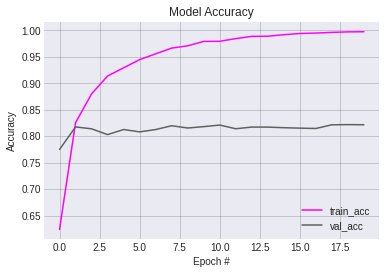

In [26]:
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(accuracies, color = 'magenta')
plt.plot(val_accuracies, color = '#606060')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train_acc', 'val_acc'], loc = 'lower right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)
plt.savefig('graphs/acc_bert.png', dpi = 100)

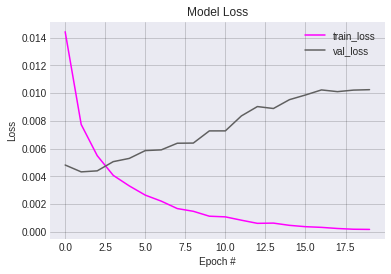

In [27]:
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(losses, color = 'magenta')
plt.plot(val_losses, color = '#606060')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(['train_loss', 'val_loss'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)
plt.savefig('graphs/loss_bert.png', dpi = 100)

In [28]:
torch.save(model.state_dict(), 'model/corona_tweets_bert_last_epoch.pth')